In [2]:
import warnings

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from numpy.polynomial.polynomial import Polynomial
from scipy.stats import pearsonr
from statsmodels.formula.api import ols

from utilities import (
    DATE_GROUPINGS,
    DYESTUFFS,
    EXOTIC,
    FOOD_PREPARATION,
    HOUSEHOLD,
    LINENS,
    LUXURY,
    PA_FULL,
    PA_OBJECTS,
    VAR_GROUPS,
    WEAPONS_AND_ARMOUR,
)

warnings.filterwarnings('ignore')


In [3]:
# Load data
df = pd.read_csv('data/dataset.csv')
key = pd.read_csv('data/key.csv')

# Melt to long format
df_long = df.melt(
    id_vars=['id', 'date_group', 'object_phrases'],
    value_vars=PA_OBJECTS,
    var_name='object_type',
    value_name='present',
)
df_long_full = df.melt(
    id_vars=['id', 'date_group', 'object_phrases'],
    value_vars=PA_FULL,
    var_name='object_type',
    value_name='present',
)

# Group by date_group and object_type
dategroup = df_long.groupby(['date_group', 'object_type'])['present'].sum().unstack(fill_value=0)
dategroup_full = df_long_full.groupby(['date_group', 'object_type'])['present'].sum().unstack(fill_value=0)


# Compare intuitive perception of household wealth against presumed metrics

This analysis looks at how an intuitive assessment of a household's wealth (`wealth_points`) compares to previously assumed objective metrics, namely the number of object phrases in the inventory (`object_phrases`) and the quantity of linens stored in the household (`total_linens`).


Correlation Results with P-Values:


,Column 1,Column 2,Correlation,P-Value
0,wealth_points,object_phrases,0.829664,5.646820e-23
1,wealth_points,total_linens,0.799579,2.701631e-20
2,object_phrases,wealth_points,0.829664,5.646820e-23
3,object_phrases,total_linens,0.760244,2.081071e-17
4,total_linens,wealth_points,0.799579,2.701631e-20
5,total_linens,object_phrases,0.760244,2.081071e-17


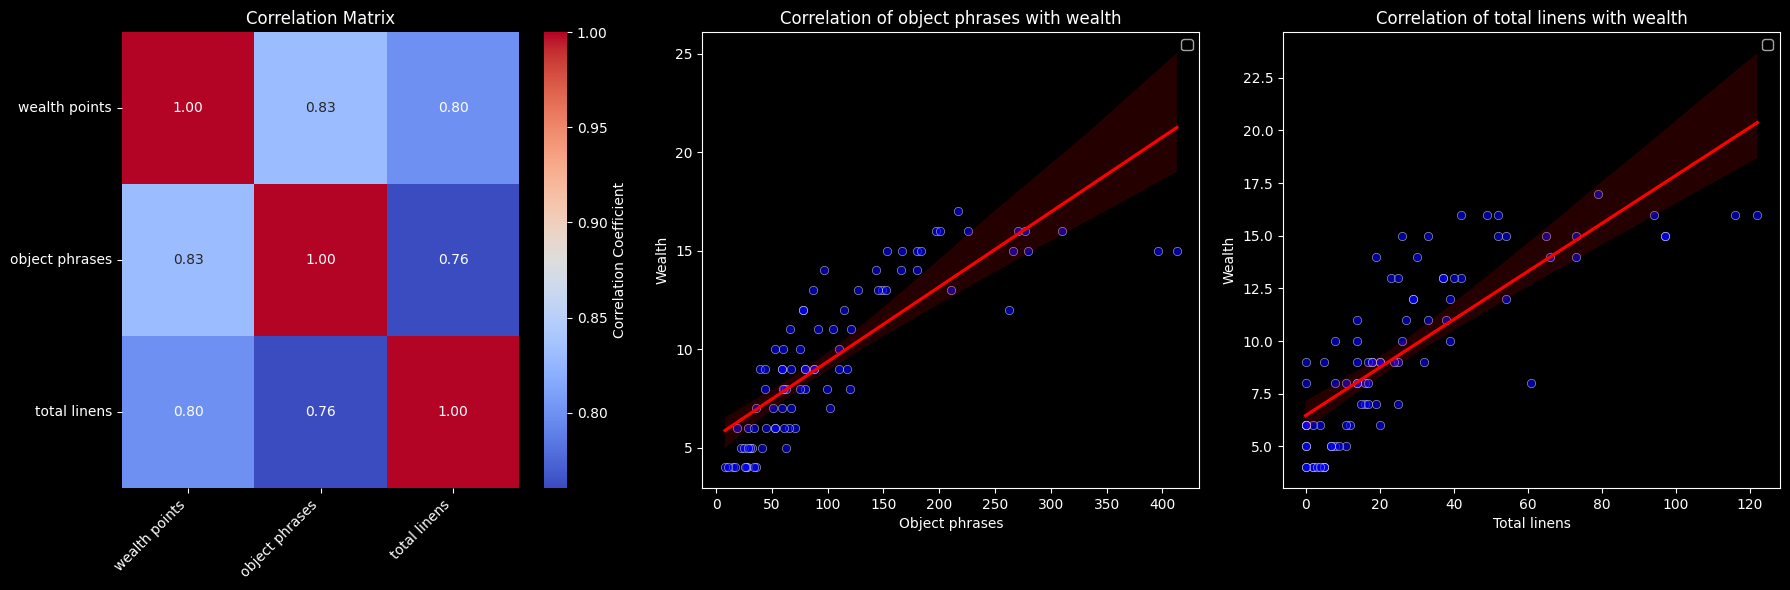

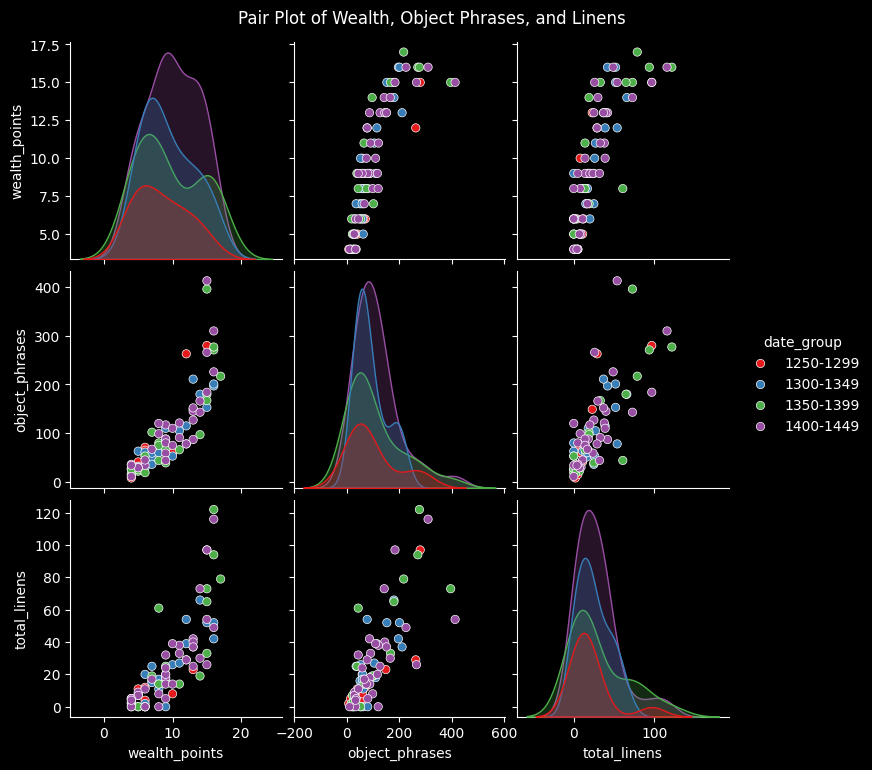

In [4]:
# Analyze correlation with p-values between wealth_points, object_phrases, and total_linens
columns_to_correlate = ['wealth_points', 'object_phrases', 'total_linens']
correlation_results = []

# Calculate correlation coefficients and p-values
for col1 in columns_to_correlate:
    for col2 in columns_to_correlate:
        if col1 != col2:
            corr, p_value = pearsonr(df[col1], df[col2])
            correlation_results.append({'Column 1': col1, 'Column 2': col2, 'Correlation': corr, 'P-Value': p_value})

# Convert results to DataFrame
correlation_results_df = pd.DataFrame(correlation_results)

# Display correlation results
print('Correlation Results with P-Values:')
display(correlation_results_df)

# Visualize results
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

# Correlation matrix
correlation_matrix = df[columns_to_correlate].corr()
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap='coolwarm',
    fmt='.2f',
    cbar_kws={'label': 'Correlation Coefficient'},
    ax=axes[0],
)
axes[0].set_title('Correlation Matrix')
axes[0].set_xticklabels(
    [label.get_text().replace('_', ' ') for label in axes[0].get_xticklabels()], rotation=45, ha='right'
)
axes[0].set_yticklabels([label.get_text().replace('_', ' ') for label in axes[0].get_yticklabels()], rotation=0)

# Visualize individual correlations
for i, col in enumerate(['object_phrases', 'total_linens'], start=1):
    sns.scatterplot(data=df, x=col, y='wealth_points', ax=axes[i], color='blue', alpha=0.6)
    sns.regplot(
        data=df,
        x=col,
        y='wealth_points',
        ax=axes[i],
        scatter=False,
        color='red',
        line_kws={'label': 'Trendline'},
    )
    axes[i].set_title(f'Correlation of {col.replace("_", " ")} with wealth')
    axes[i].set_xlabel(col.replace('_', ' ').capitalize())
    axes[i].set_ylabel('Wealth')
    axes[i].legend()

plt.tight_layout()
plt.show()

# Pair Plot: Visualize pairwise relationships between variables
sns.pairplot(
    df[['wealth_points', 'object_phrases', 'total_linens', 'date_group']],
    diag_kind='kde',
    corner=False,
    hue='date_group',
    palette='Set1',
)
plt.suptitle('Pair Plot of Wealth, Object Phrases, and Linens', y=1.02)
plt.show()


## Interpretation

All correlations are strong and statistically significant, with p-values far below 0.05. Wealth is strongly correlated with both the number of object phrases and the quantity of linens in a household.

**Wealth (`wealth_points`) and Object phrases (`object_phrases`):**
- Correlation: 0.830 (strong positive correlation)
- P-Value: 5.65e-23 (highly statistically significant)

**Wealth (`wealth_points`) and Quantity of linens (`total_linens`):**
- Correlation: 0.800 (strong positive correlation)
- P-Value: 2.70e-20 (highly statistically significant)

**Object phrases (`object_phrases`) and Quantity of linens (`total_linens`):**
- Correlation: 0.760 (strong positive correlation)
- P-Value: 2.08e-17 (highly statistically significant)


# How do indicators of wealth and the number of object phrases per inventory change over time?


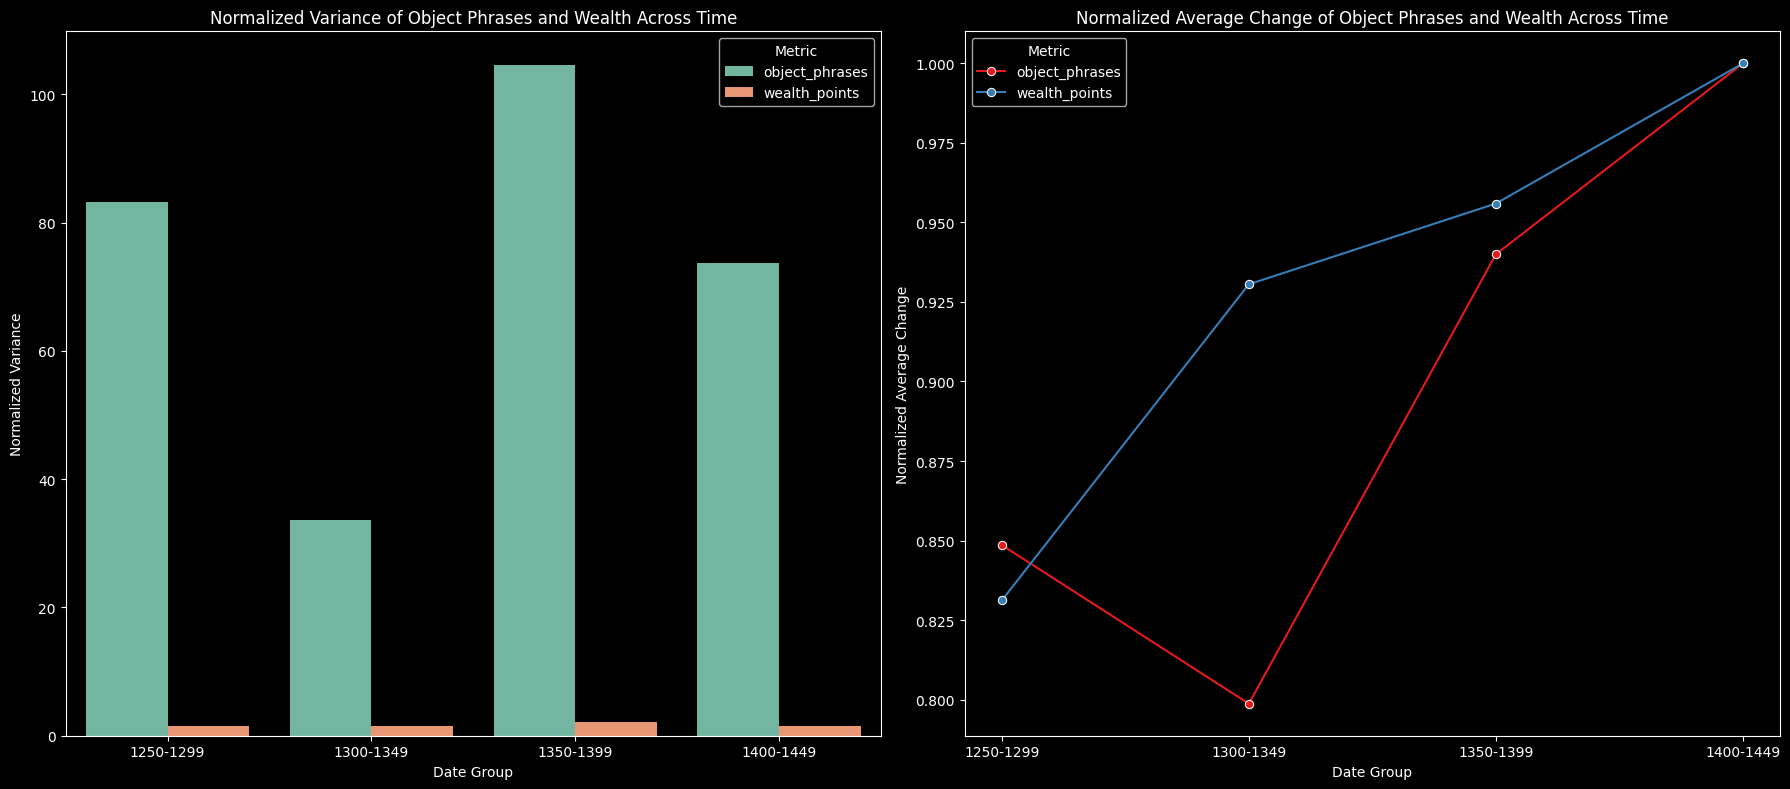

  date_group  object_phrases  wealth_points
0  1250-1299        0.848584       0.831169
1  1300-1349        0.798714       0.930548
2  1350-1399        0.939994       0.955930
3  1400-1449        1.000000       1.000000
  date_group  object_phrases  wealth_points
0  1250-1299       83.159417       1.491351
1  1300-1349       33.630811       1.460191
2  1350-1399      104.619187       2.212525
3  1400-1449       73.731202       1.464298


In [13]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 8))

# Compare variance across time between 'object_phrases' and 'wealth_points' across 'DATE_GROUPINGS'
df['date_group'] = df['year'].apply(
    lambda x: next((group for group, years in DATE_GROUPINGS.items() if x in years), 'Unknown')
    if 'year' in df.columns
    else 'Unknown'
)

# Group by 'date_group' and calculate variance
variance_df = df.groupby('date_group')[['object_phrases', 'wealth_points']].var().reset_index()

# Normalize variance by dividing by the mean of each column
mean_values = df[['object_phrases', 'wealth_points']].mean()
variance_df[['object_phrases', 'wealth_points']] = variance_df[['object_phrases', 'wealth_points']].div(
    mean_values, axis=1
)

# Plot normalized variance comparison
sns.barplot(
    data=variance_df.melt(id_vars='date_group', var_name='Metric', value_name='Normalized Variance'),
    x='date_group',
    y='Normalized Variance',
    hue='Metric',
    palette='Set2',
    ax=axes[0],
)
axes[0].set_title('Normalized Variance of Object Phrases and Wealth Across Time')
axes[0].set_xlabel('Date Group')
axes[0].set_ylabel('Normalized Variance')
plt.legend(title='Metric')
plt.xticks()
plt.tight_layout()


# Compare average change across time between 'object_phrases' and 'wealth_points'
# Calculate average change for each metric within each date group
average_change_df = df.groupby('date_group')[['object_phrases', 'wealth_points']].mean().reset_index()

# Normalize the average change by dividing by the maximum value of each column
max_values = average_change_df[['object_phrases', 'wealth_points']].max()
average_change_df[['object_phrases', 'wealth_points']] = average_change_df[['object_phrases', 'wealth_points']].div(
    max_values,
    axis=1,
)

# Plot normalized average change comparison
sns.lineplot(
    data=average_change_df.melt(id_vars='date_group', var_name='Metric', value_name='Normalized Average Change'),
    x='date_group',
    y='Normalized Average Change',
    hue='Metric',
    marker='o',
    palette='Set1',
    ax=axes[1],
)
axes[1].set_title('Normalized Average Change of Object Phrases and Wealth Across Time')
axes[1].set_xlabel('Date Group')
axes[1].set_ylabel('Normalized Average Change')
plt.legend(title='Metric')
plt.xticks()
plt.tight_layout()
plt.show()

print(average_change_df)

print(variance_df)


## Interpretation

The period 1350-1399 stands out with the highest variance in both `object_phrases` and `wealth_points`, indicating significant changes or disparities during this time.
Variance in `object_phrases` is consistently higher than in `wealth_points`, suggesting that household inventories were more diverse than wealth distribution across all periods.
The stabilization of `wealth_points` variance in 1400-1449 may reflect economic recovery or consolidation after a period of upheaval.

**1250-1299**
- `object_phrases` variance: 8733.67 (high variability in the number of object phrases, indicating diverse household inventories during this period).
- `wealth_points` variance: 14.25 (relatively low variability, suggesting more consistent wealth distribution).

**1300-1349**
- `object_phrases` variance: 3532.02 (significant drop in variability compared to the previous period, indicating more uniform household inventories).
- `wealth_points` variance: 13.96 (similar to the previous period, showing consistent wealth distribution).

**1350-1399**
- `object_phrases` variance: 10987.45 (sharp increase in variability, suggesting a period of significant diversity in household inventories).
- `wealth_points` variance: 21.15 (highest variability across all periods, reflecting greater economic disparities or changes in wealth distribution).

**1400-1449**
- `object_phrases` variance: 7743.49 (decrease from the previous period but still relatively high, indicating continued diversity in inventories).
- `wealth_points` variance: 13.99 (return to lower variability, suggesting a stabilization in wealth distribution).



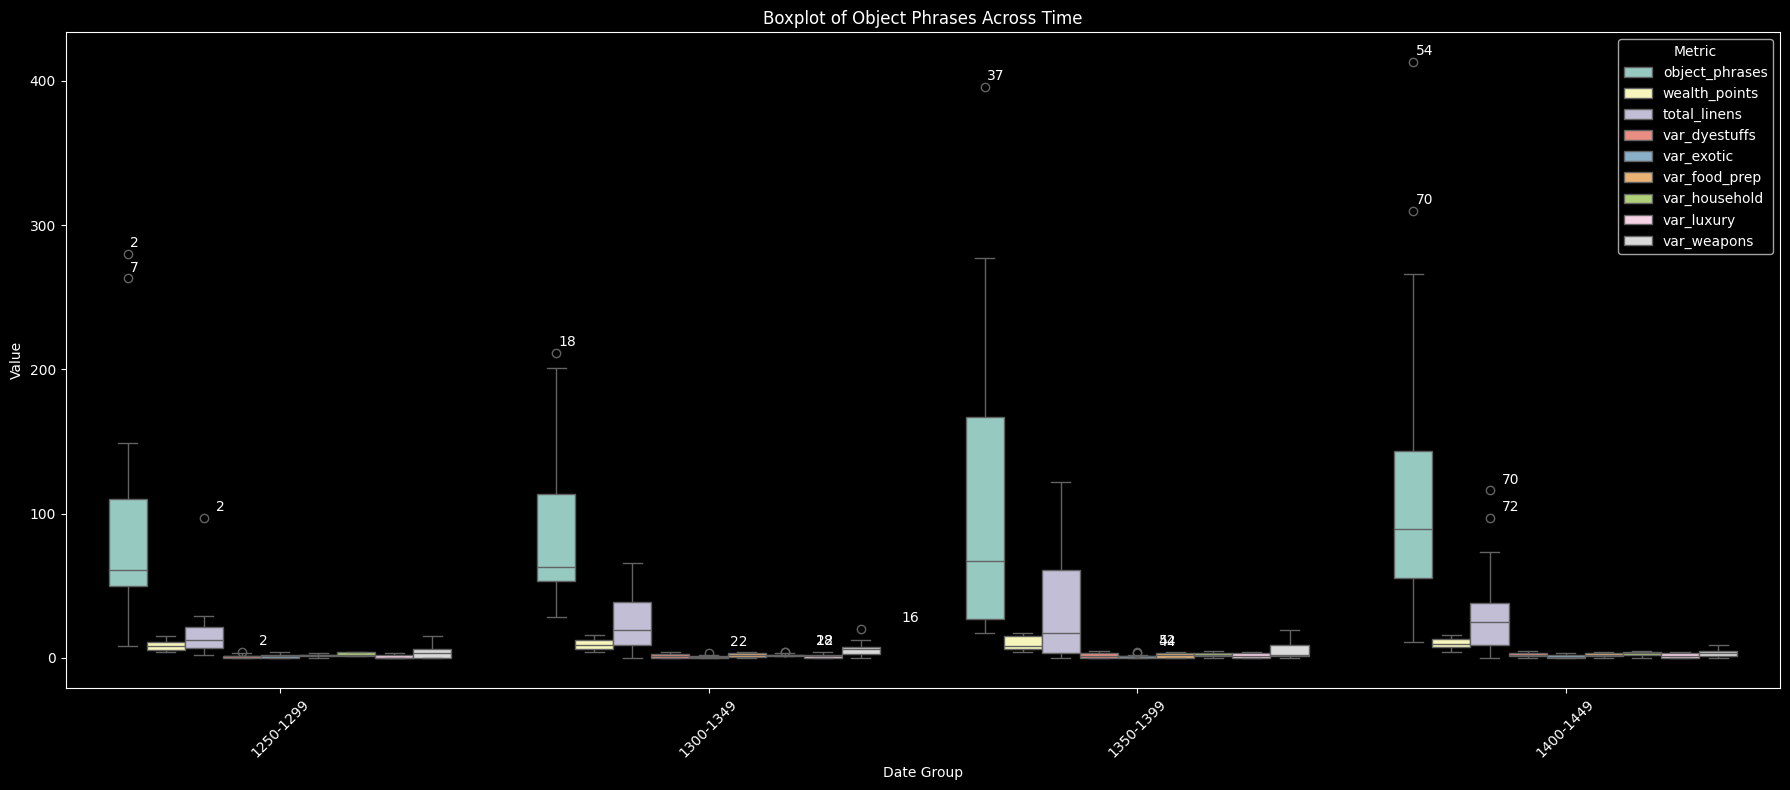

Outliers:


,record,type,year,date_group
2,Colratus Cavallerii (AMM 1 II 21),Inventory-Guardianship,1295,1250-1299
7,Ricardus Jullani (AMM FF 501),Inventory-Guardianship,1297,1250-1299
16,Fulco Amati (ADBR 3B 32),Inventory-Guardianship,1336,1300-1349
18,Guillelmus Egidii (AMM 1 II 58),Inventory-Postmortem,1347,1300-1349
22,Franciscus de Serralonga (ADBR 355E 1),Inventory-Postmortem,1348,1300-1349
37,Berengarius de Bulbono (AMM 2 II 291),Inventory-Postmortem,1360,1350-1399
44,Andreas de Garda (ADBR 392E 1),Inventory-Guardianship,1394,1350-1399
52,Antonius Fabri (ADBR 3B 128),Inventory-Postmortem,1397,1350-1399
54,Philipponus Colini (ADBR 5G 771),Inventory-Postmortem,1400,1400-1449
70,Rixendis Cambale (ADBR 355E 309),Inventory-Guardianship,1410,1400-1449


In [6]:
plt.figure(figsize=(18, 8))

target_columns = ['object_phrases', 'wealth_points', 'total_linens', *VAR_GROUPS]
plot_data = df.melt(
    id_vars=['id', 'date_group'],
    value_vars=target_columns,
    var_name='Metric',
    value_name='Value',
)

sns.boxplot(
    data=plot_data,
    x='date_group',
    y='Value',
    palette='Set3',
    hue='Metric',
)
plt.title('Boxplot of Object Phrases Across Time')
plt.xlabel('Date Group')
plt.ylabel('Value')
plt.tick_params(axis='x', rotation=45)
plt.tight_layout()

# Add outlier labels
outliers = []
num_metrics = len(target_columns)  # Total number of metrics
for i, metric in enumerate(target_columns, start=1):
    for group_index, group in enumerate(DATE_GROUPINGS):
        df_group = df[df['date_group'] == group]
        for _, row in df_group.iterrows():
            if row[metric] > df_group[metric].quantile(0.75) + 1.5 * (
                df_group[metric].quantile(0.75) - df_group[metric].quantile(0.25)
            ):
                outliers.append(row['id'])
                # Calculate x position for annotation
                x_offset = (i - num_metrics / 2) * 0.1  # Adjust the multiplier (e.g., 0.1) for spacing
                x_pos = group_index + x_offset
                plt.annotate(
                    str(row['id']),
                    xy=(x_pos, row[metric]),
                    xytext=(0, 5),
                    textcoords='offset points',
                    fontsize=10,
                )


plt.show()

# results = plot_data.groupby(['date_group', 'Metric'])['Value'].describe()
# display(results)

# print data for outliers, include id, record, type, year, and date_group
print('Outliers:')
display(df[df['id'].isin(outliers)][['record', 'type', 'year', 'date_group']])


## Interpretation

In the period from 1250 to 1299 the number of object phrases per inventory and the quantity of linens per hosehold show high variability, indicating diverse inventories. Wealth, on the other hand, shows low variability, suggesting consistent wealth distribution across households.
Between 1300 and 1349 most metrics show decreased varibility suggesting more uniform inventories and wealth distribution. In the period from 1350 to 1399 the number of object phrases, the quantity of linens, and wealth overall reach peak variabilty suggesting significant material diversity and economic disparities. Finally, between 1400 and 1449 wealth and quantity of linens stabilize, suggesting economic recovery or consolidation. High variability in the number of object phrases persists, however, likely reflecting continued diversity in inventories or changes in inventory practices.

**Object Phrases (`object_phrases`):**
- 1250-1299: Mean = 97.45, Std = 93.45. High variability with a wide range (8 to 280), indicating diverse household inventories.
- 1300-1349: Mean = 91.73, Std = 59.43. Variability decreases compared to the previous period, suggesting more uniform inventories.
- 1350-1399: Mean = 107.95, Std = 104.82. Variability peaks, reflecting significant diversity in household inventories.
- 1400-1449: Mean = 114.84, Std = 87.99. Variability remains high, but slightly less than the previous period.

**Wealth (`wealth_points`):**
- 1250-1299: Mean = 8.36, Std = 3.78. Low variability, indicating consistent wealth distribution.
- 1300-1349: Mean = 9.36, Std = 3.74. Similar variability to the previous period.
- 1350-1399: Mean = 9.62, Std = 4.60. Variability increases, reflecting greater economic disparities.
- 1400-1449: Mean = 10.06, Std = 3.74. Variability stabilizes, suggesting economic recovery or consolidation.

**Quantity of Linens (`total_linens`):**
- 1250-1299: Mean = 20.64, Std = 26.69. High variability, indicating diverse textile inventories.
- 1300-1349: Mean = 24.18, Std = 19.77. Variability decreases, suggesting more uniform textile inventories.
- 1350-1399: Mean = 31.48, Std = 35.92. Variability peaks, reflecting significant diversity in textile inventories.
- 1400-1449: Mean = 28.63, Std = 26.94. Variability decreases but remains relatively high.

**Other Metrics (`var_dyestuff`, `var_exotic`, `var_weapons`):**
- Dyestuffs: Variability increases over time, peaking in 1400-1449 (Mean = 2.03, Std = 1.64).
- Exotic Objects: Variability remains relatively low across all periods.
- Weapons: Variability peaks in 1350-1399 (Mean = 5.29, Std = 6.14), then decreases in 1400-1449.


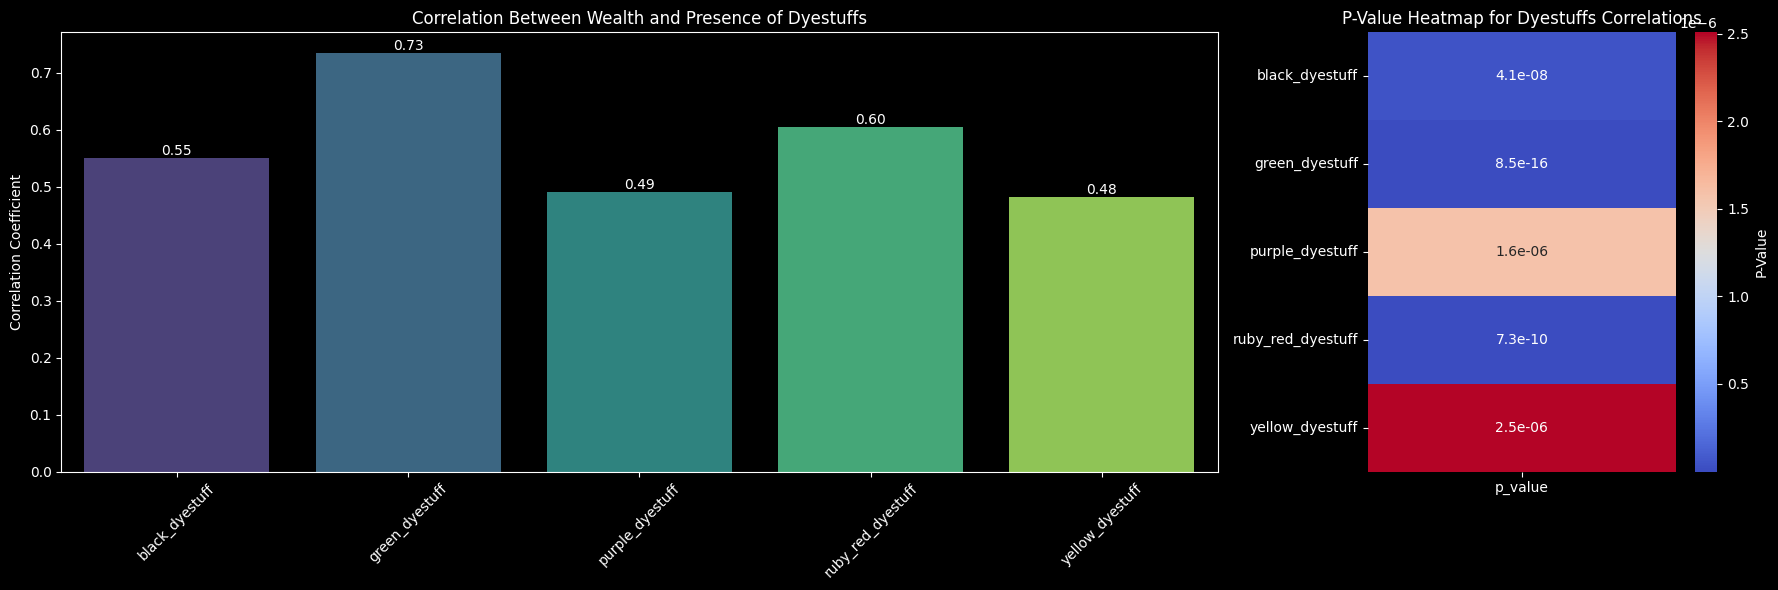

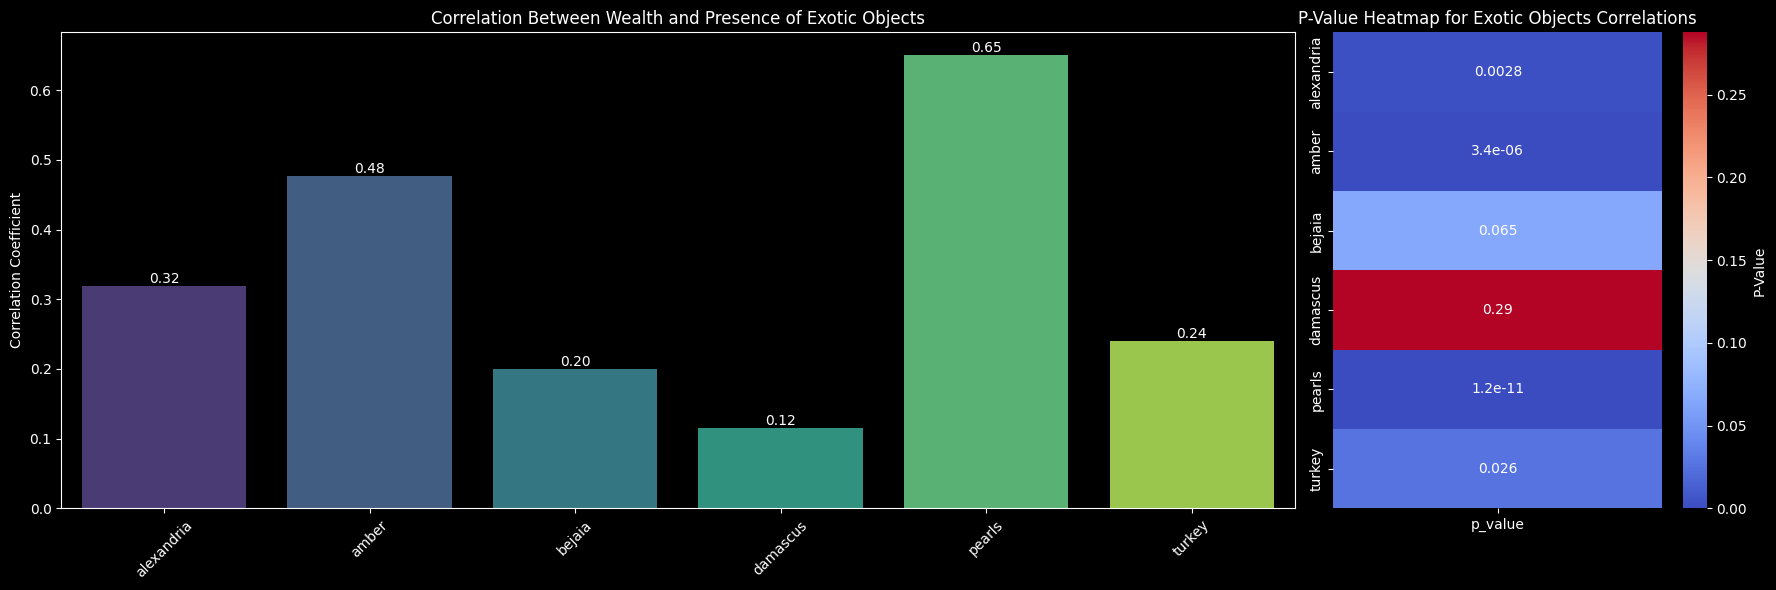

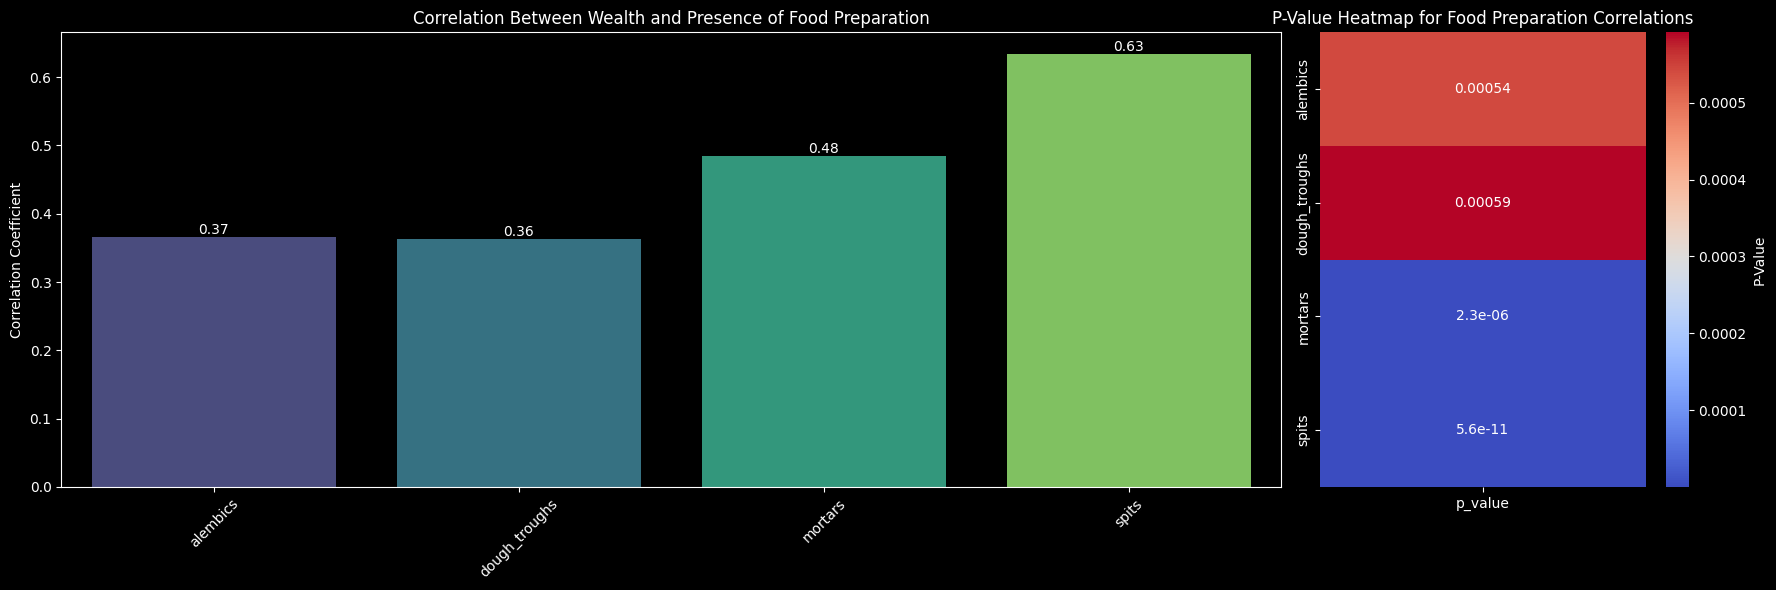

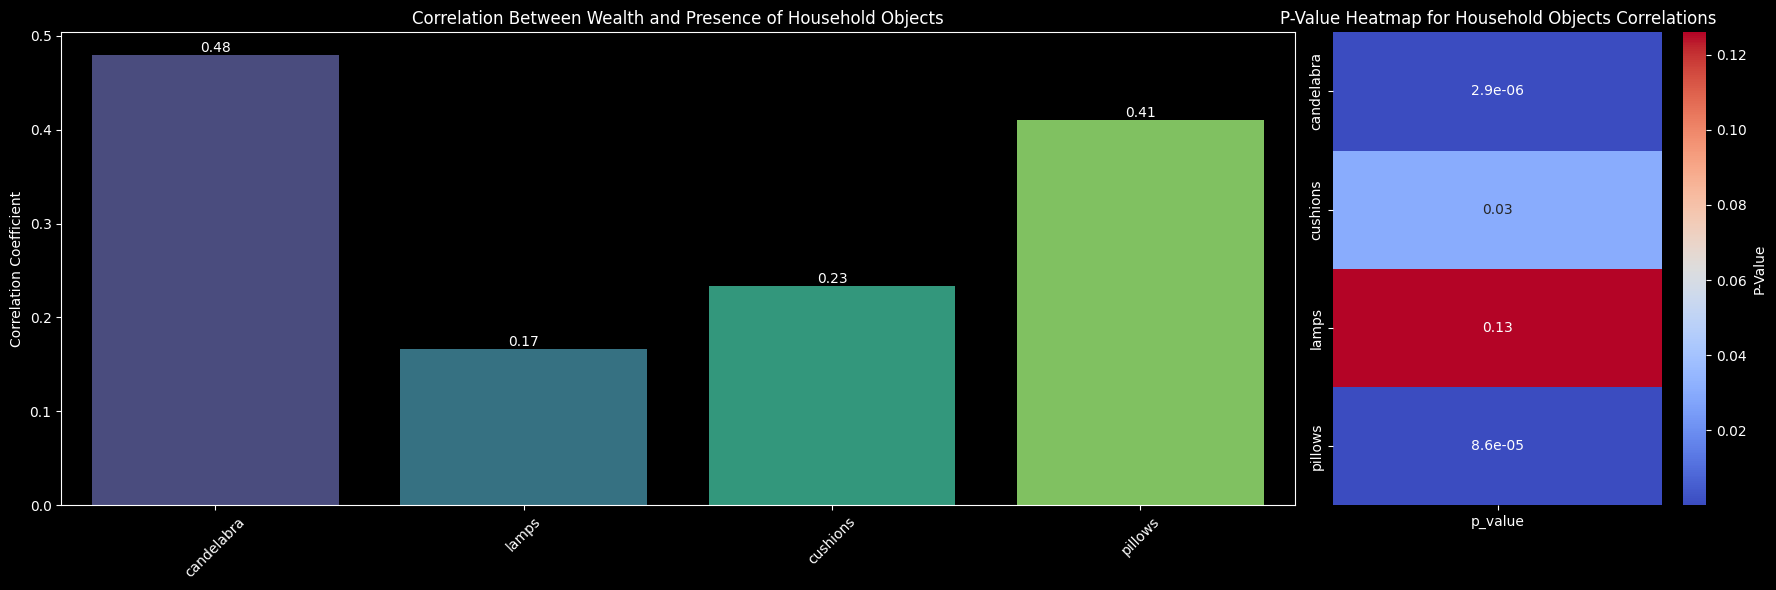

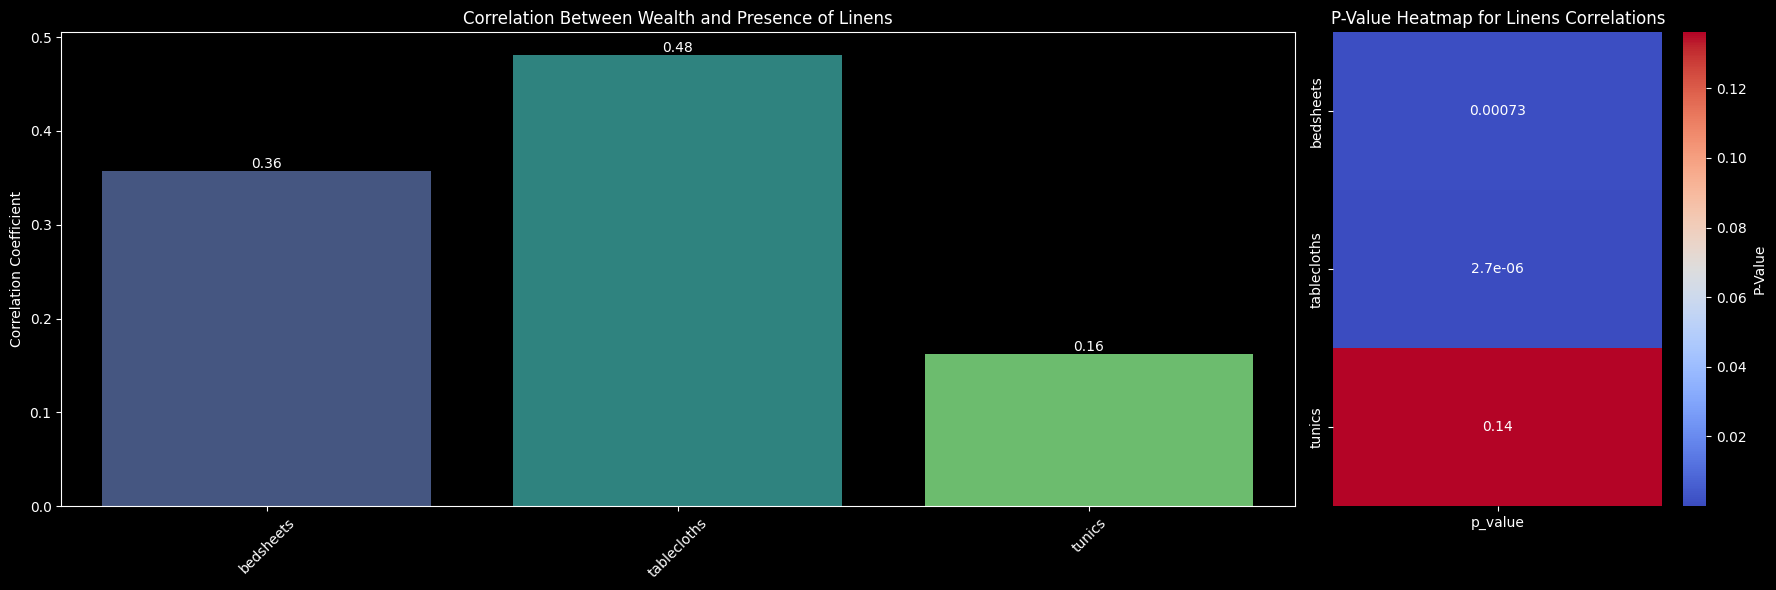

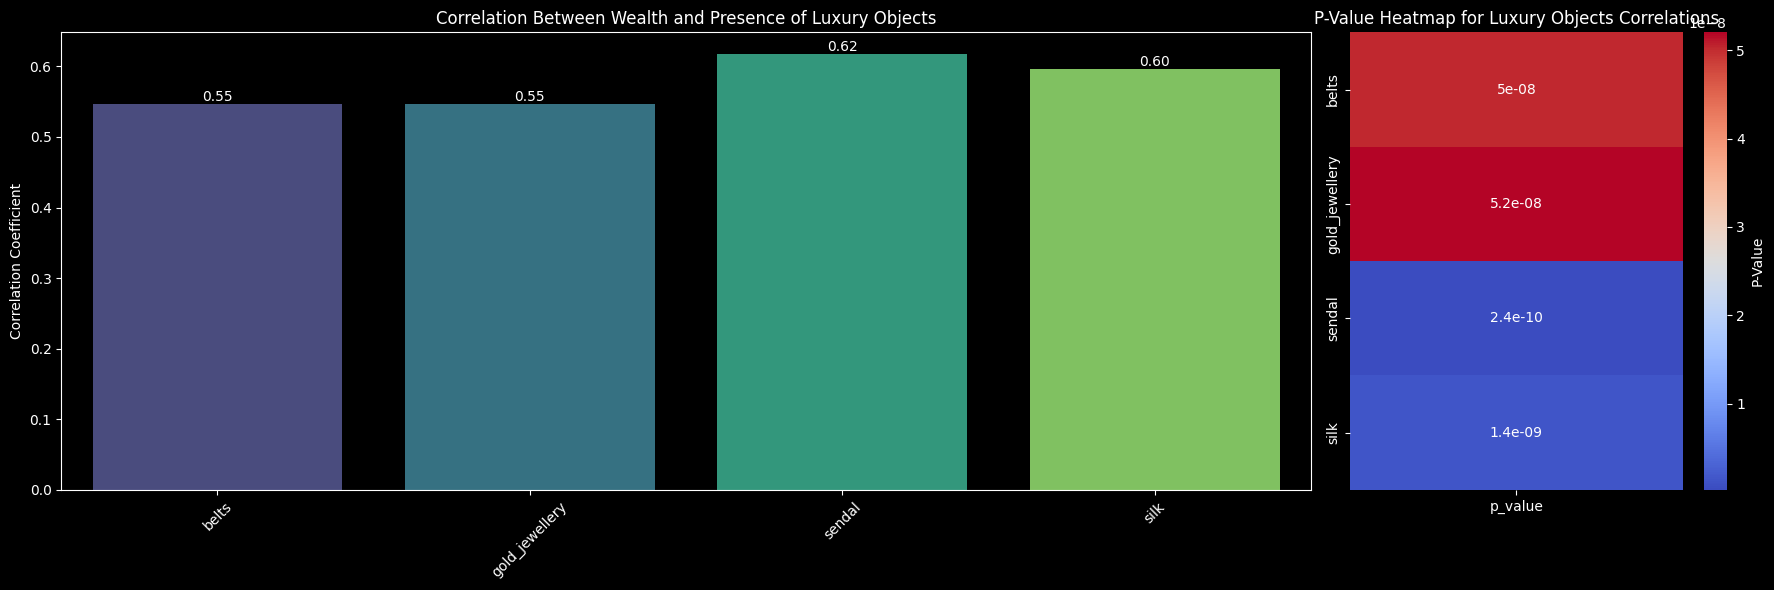

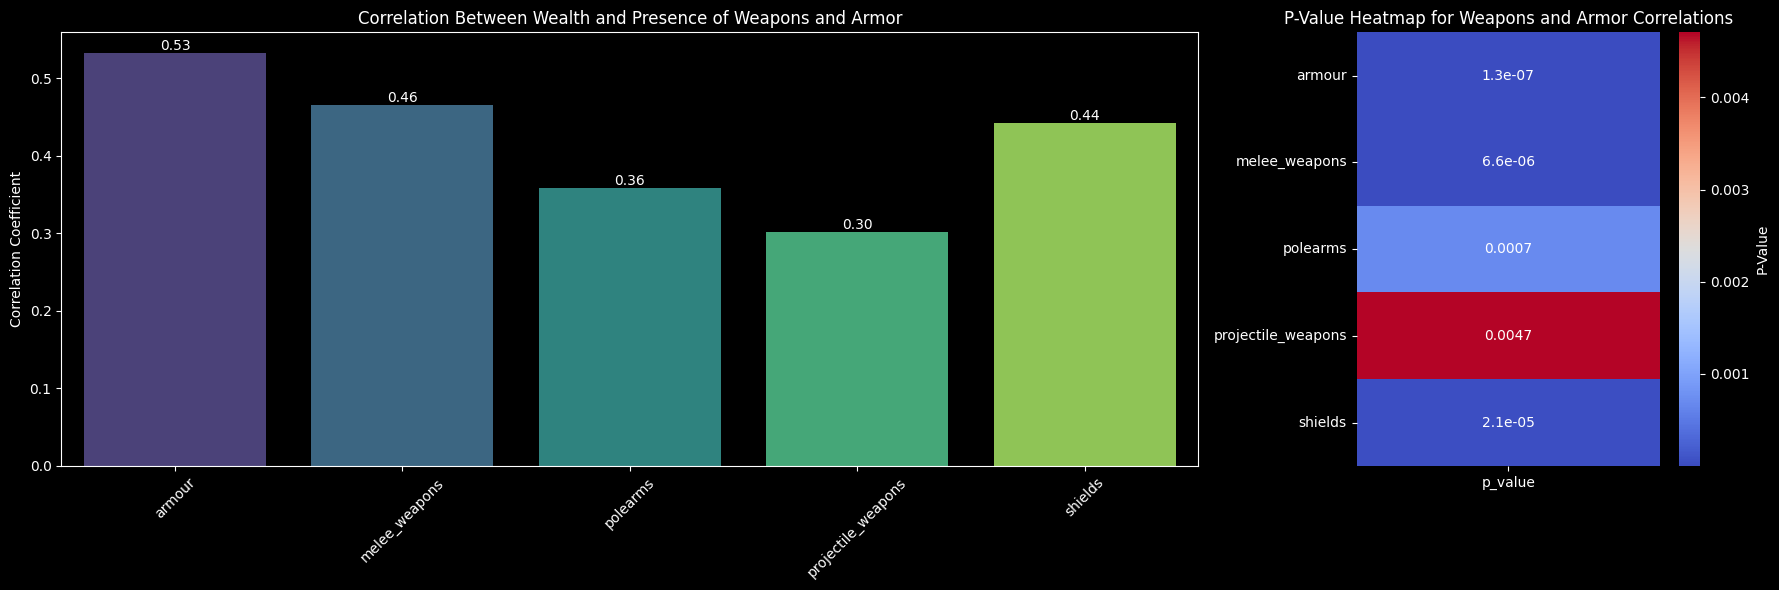

In [7]:
# Calculate correlation coefficients and p-values for object groups
obj_groups = {
    'Dyestuffs': DYESTUFFS,
    'Exotic Objects': EXOTIC,
    'Food Preparation': FOOD_PREPARATION,
    'Household Objects': HOUSEHOLD,
    'Linens': LINENS,
    'Luxury Objects': LUXURY,
    'Weapons and Armor': WEAPONS_AND_ARMOUR,
}

for group_name, group_columns in obj_groups.items():
    correlation_results = []

    # Individual correlations
    for col in group_columns:
        corr, p_value = pearsonr(df[col], df['wealth_points'])
        correlation_results.append({'column': col, 'correlation': corr, 'p_value': p_value})

    # Convert results to DataFrame
    correlation_df = pd.DataFrame(correlation_results)

    # Visualize correlation results
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18, 6), width_ratios=[3, 1])
    sns.barplot(data=correlation_df, x='column', y='correlation', palette='viridis', ci='sd', ax=ax1)

    for index, row in correlation_df.iterrows():
        ax1.text(index, row['correlation'], f'{row["correlation"]:.2f}', ha='center', va='bottom')

    ax1.set_title(f'Correlation Between Wealth and Presence of {group_name}')
    ax1.set_ylabel('Correlation Coefficient')
    ax1.set_xlabel(None)
    ax1.set_xticklabels(correlation_df['column'], rotation=45)
    sns.heatmap(
        correlation_df.pivot_table(index='column', values='p_value'),
        annot=True,
        cmap='coolwarm',
        cbar_kws={'label': 'P-Value'},
        ax=ax2,
    )
    ax2.set_title(f'P-Value Heatmap for {group_name} Correlations')
    ax2.set_xlabel(None)
    ax2.set_ylabel(None)
    plt.tight_layout()
    plt.show()


# Do gender and/or faith have any effect on the distribution of wealth?


Two-Way ANOVA Results:
                         sum_sq    df         F    PR(>F)
C(gender)             15.787282   1.0  1.009545  0.317968
C(faith)               1.711432   1.0  0.109440  0.741626
C(gender):C(faith)    17.790375   1.0  1.137636  0.289283
Residual            1282.317460  82.0       NaN       NaN


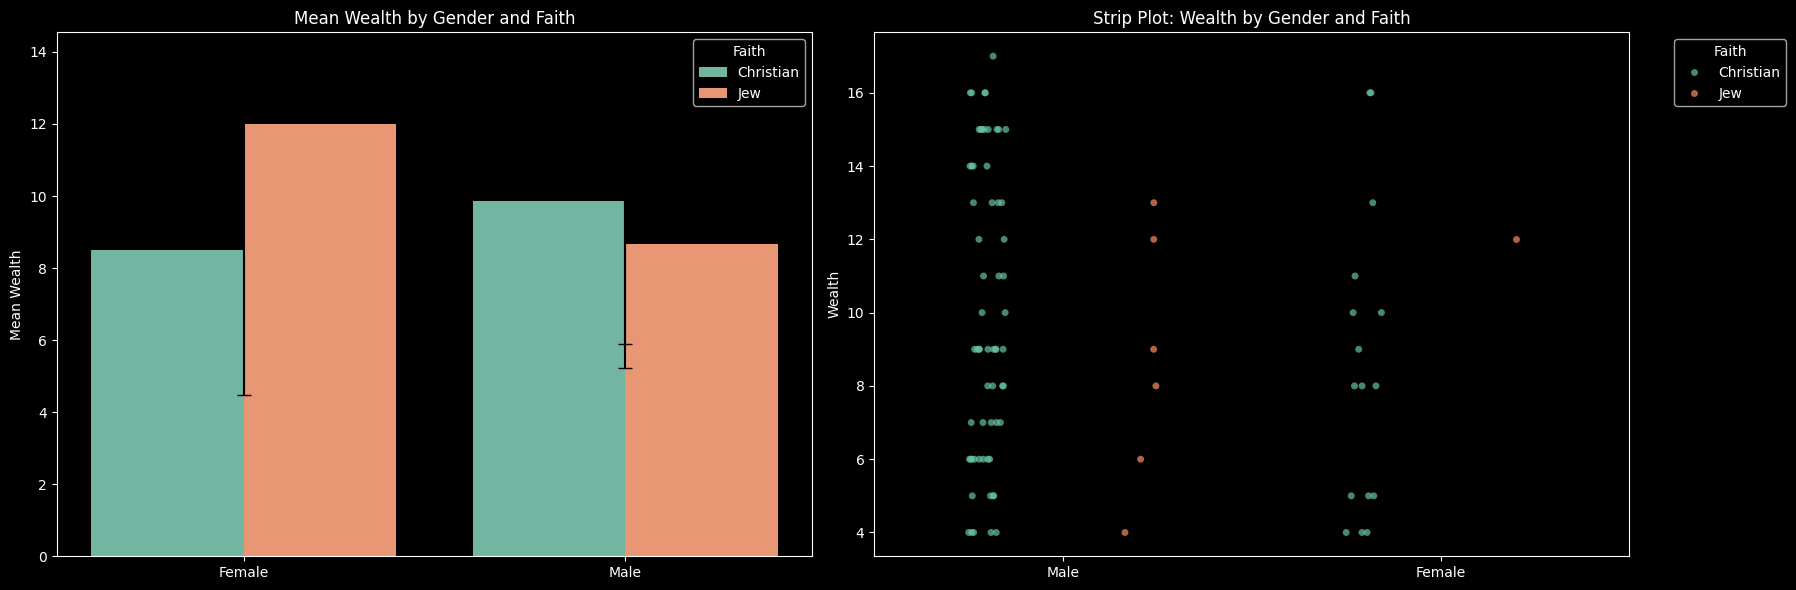

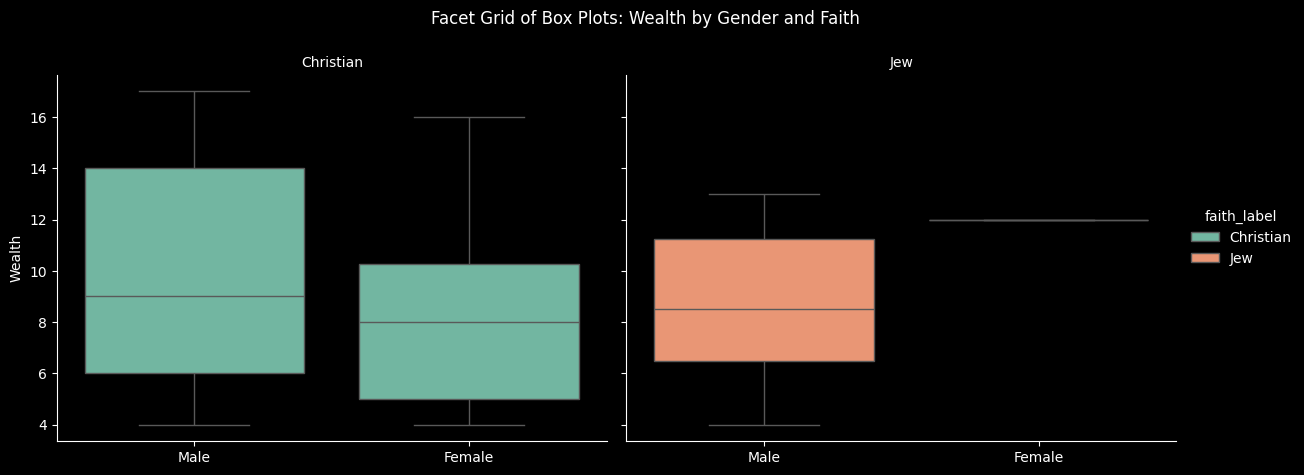

In [8]:
# Analyze the relationship between wealth (wealth_points), gender, and faith
# Two-way ANOVA
anova_model = ols('wealth_points ~ C(gender) * C(faith)', data=df).fit()
anova_table = sm.stats.anova_lm(anova_model, typ=2)
print('Two-Way ANOVA Results:')
print(anova_table)

# Group data by gender and faith to calculate mean and standard deviation of wealth_points
grouped_data = df.groupby(['gender_label', 'faith_label'])['wealth_points'].agg(['mean', 'std', 'count']).reset_index()

# Visualization:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

# Bar plot with error bars
sns.barplot(data=grouped_data, x='gender_label', y='mean', hue='faith_label', palette='Set2', ci=None, ax=axes[0])
for i, row in grouped_data.iterrows():
    axes[0].errorbar(
        x=i // len(grouped_data['faith_label'].unique()),
        y=row['mean'],
        yerr=row['std'],
        fmt='none',
        c='black',
        capsize=5,
    )
axes[0].set_title('Mean Wealth by Gender and Faith')
axes[0].set_xlabel('')
axes[0].set_ylabel('Mean Wealth')
# set legend using label columns
axes[0].legend(title='Faith', labels=grouped_data['faith_label'].unique())
# Strip Plot
sns.stripplot(
    data=df,
    x='gender_label',
    y='wealth_points',
    hue='faith_label',
    dodge=True,
    jitter=True,
    alpha=0.7,
    palette='Set2',
    ax=axes[1],
)
axes[1].set_title('Strip Plot: Wealth by Gender and Faith')
axes[1].set_xlabel('')
axes[1].set_ylabel('Wealth')
axes[1].legend(title='Faith', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Facet Grid of Box Plots
facet_grid = sns.catplot(
    data=df,
    x='gender_label',
    y='wealth_points',
    hue='faith_label',
    kind='box',
    col='faith_label',
    col_wrap=2,
    height=5,
    aspect=1.2,
    palette='Set2',
)
facet_grid.set_axis_labels('', 'Wealth')
facet_grid.set_titles(col_template='{col_name}')
facet_grid.set_xticklabels()
facet_grid.set_ylabels('Wealth')
facet_grid.fig.suptitle('Facet Grid of Box Plots: Wealth by Gender and Faith')
facet_grid.fig.subplots_adjust(top=0.85)


## Interpretation

The effect of gender on wealth is not statistically significant (p > 0.05), and either is the effect of faith (p > 0.05), nor that of both gender and faith combined (p > 0.05). The residual sum of squares (1282.3175) represents the unexplained variance in the model and suggests that most of the variability in wealth is not explained by gender, faith, or their interaction. Based on this date we can conclude that neither gender, faith, nor their interaction significantly affects wealth and that its variability must be attributed to other factors not included in the analysis. 

**Main Effect of Gender (`C(gender)`):**
- F-value: 1.0095
- p-value (PR(>F)): 0.3180

**Main Effect of Faith (`C(faith)`):**
- F-value: 0.1094
- p-value (PR(>F)): 0.7416

**Interaction Effect (`C(gender):C(faith)`):**
- F-value: 1.1376
- p-value (PR(>F)): 0.2893


# Can we detect changes in household wealth across time?

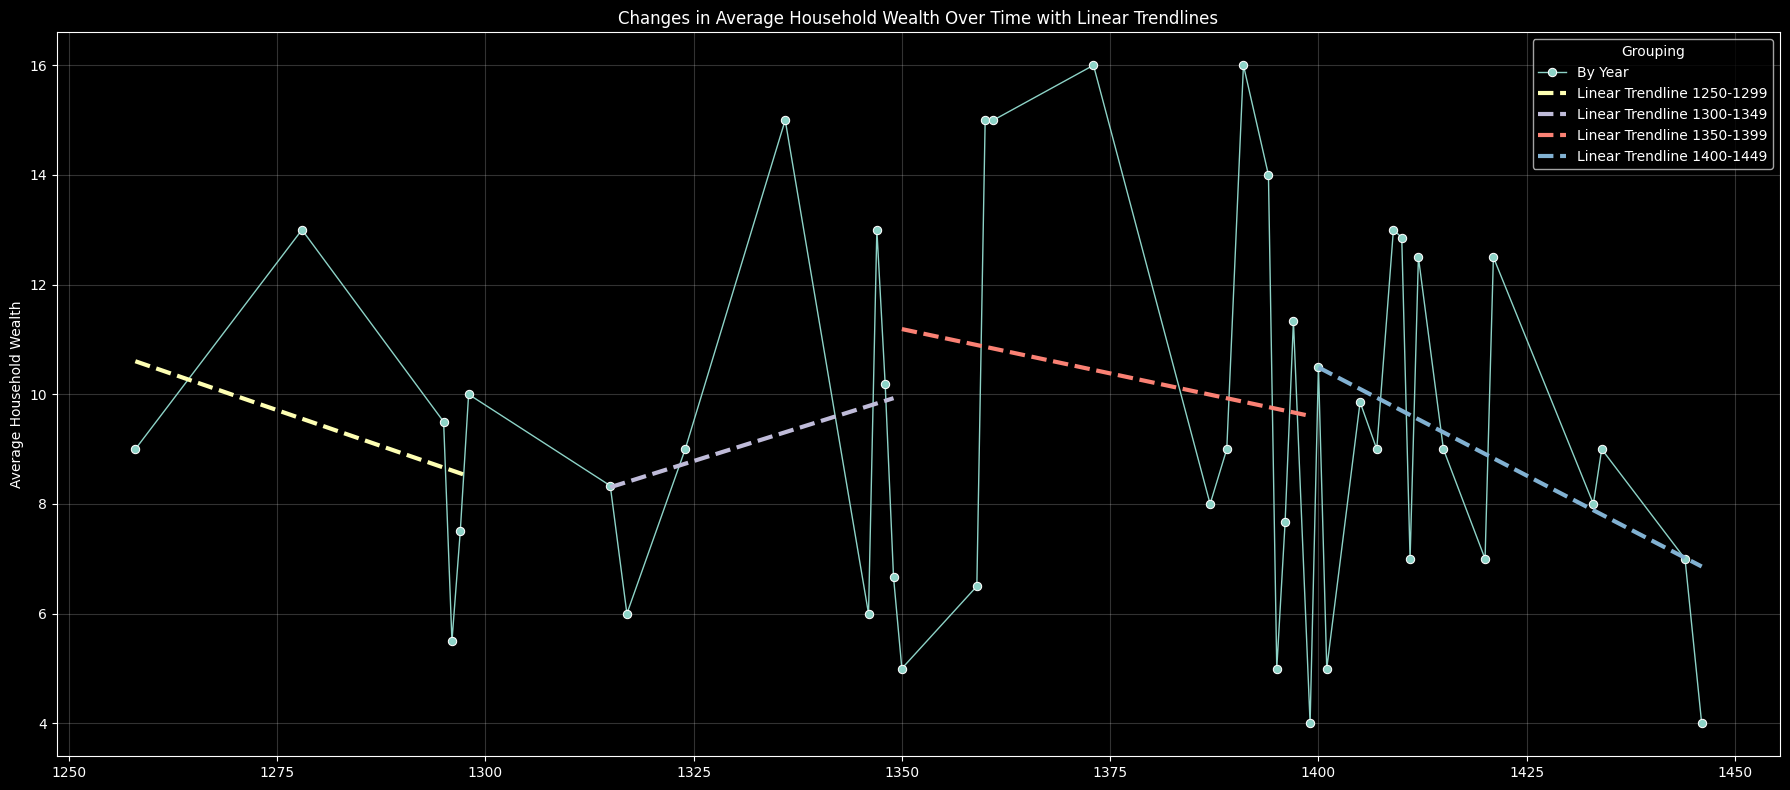

In [11]:
# Calculate average household wealth by year
average_wealth_by_year = df.groupby('year')['wealth_points'].mean().reset_index()

# Add interval trendlines to the chart
plt.figure(figsize=(18, 8))
sns.lineplot(data=average_wealth_by_year, x='year', y='wealth_points', marker='o', label='By Year', linewidth=1)


# Add linear trendlines for each interval
def add_linear_trendlines(ax, date_groupings, df):
    """Add linear trendlines for each date grouping."""
    for group, year_range in date_groupings.items():
        interval_data = df[df['year'].isin(year_range)].groupby('year')['wealth_points'].mean().reset_index()
        if not interval_data.empty:
            # Fit a linear trendline
            p = Polynomial.fit(interval_data['year'], interval_data['wealth_points'], 1)
            trendline = p(interval_data['year'])
            ax.plot(interval_data['year'], trendline, linestyle='--', linewidth=3, label=f'Linear Trendline {group}')


ax = plt.gca()
add_linear_trendlines(ax, DATE_GROUPINGS, df)

plt.title('Changes in Average Household Wealth Over Time with Linear Trendlines')
plt.xlabel(None)
plt.ylabel('Average Household Wealth')
plt.legend(title='Grouping')
plt.grid(True, alpha=0.2)  # noqa: FBT003
plt.tight_layout()
plt.show()


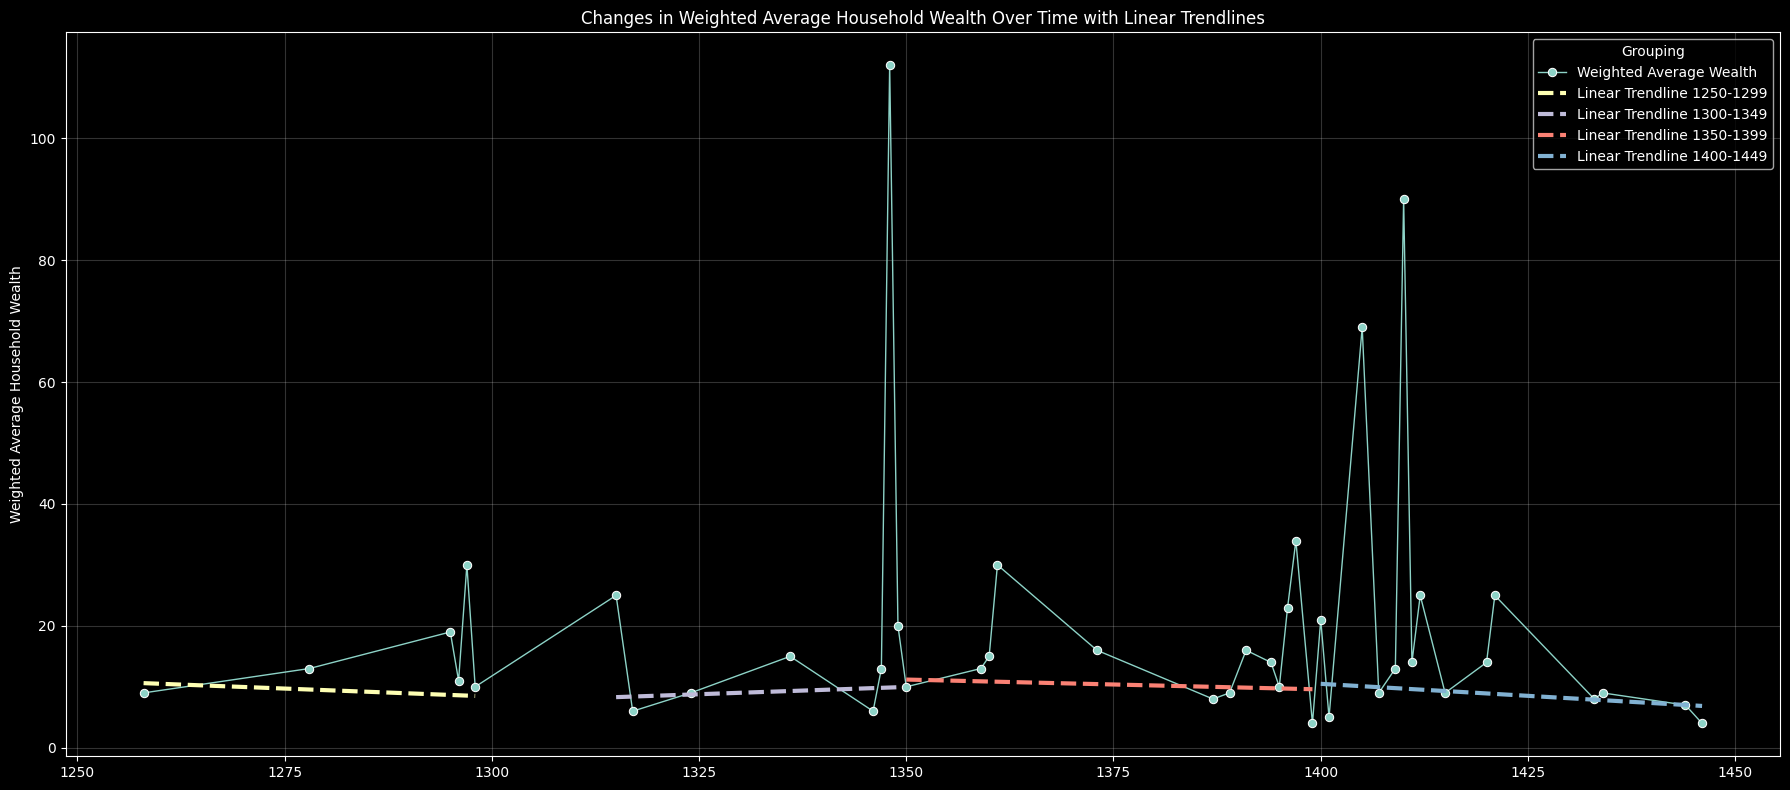

In [12]:
# Calculate weighted average household wealth by year
weighted_wealth_by_year = (
    df.groupby('year').apply(lambda x: (x['wealth_points'] * x['id'].count()).sum() / x['id'].count()).reset_index()
)
weighted_wealth_by_year.columns = ['year', 'weighted_average_wealth']

# Plot weighted average household wealth by year
plt.figure(figsize=(18, 8))
sns.lineplot(
    data=weighted_wealth_by_year,
    x='year',
    y='weighted_average_wealth',
    marker='o',
    label='Weighted Average Wealth',
    linewidth=1,
)


# Add linear trendlines for each interval
def add_linear_trendlines(ax, date_groupings, df):
    """Add linear trendlines for each date grouping."""
    for group, year_range in date_groupings.items():
        interval_data = df[df['year'].isin(year_range)].groupby('year')['wealth_points'].mean().reset_index()
        if not interval_data.empty:
            # Fit a linear trendline
            p = Polynomial.fit(interval_data['year'], interval_data['wealth_points'], 1)
            trendline = p(interval_data['year'])
            ax.plot(interval_data['year'], trendline, linestyle='--', linewidth=3, label=f'Linear Trendline {group}')


ax = plt.gca()
add_linear_trendlines(ax, DATE_GROUPINGS, df)

plt.title('Changes in Weighted Average Household Wealth Over Time with Linear Trendlines')
plt.xlabel(None)
plt.ylabel('Weighted Average Household Wealth')
plt.legend(title='Grouping')
plt.grid(True, alpha=0.2)  # noqa: FBT003
plt.tight_layout()
plt.show()
